In [1]:
import os
import tarfile
from pathlib import Path
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16, InceptionV3, DenseNet201, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [2]:
# Step 2: Load images and labels
def load_images_and_labels(base_path):
    images = []
    labels = []
    for fold in ['FOLD 1', 'FOLD 2', 'FOLD 3']:
        fold_path = Path(base_path) / fold
        for label in ['He', 'Hbv', 'Le', 'IPCL']:
            class_path = fold_path / label
            for img_path in class_path.glob('*.png'):
                img = cv2.imread(str(img_path))
                img = cv2.resize(img, (100, 100)) 
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


In [3]:
images, labels = load_images_and_labels("laryngeal dataset")
label_names = ['He', 'Hbv', 'Le', 'IPCL']

In [4]:
# Step 3: Apply Gaussian filter
def apply_gaussian_filter(images, kernel_size=(5, 5), sigma=0.9):
    filtered_images = []
    for img in images:
        # Ensure the image is in grayscale
        # if len(img.shape) == 3:
        #     image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # else:
        image = img  # If already in grayscale, use as is

        # # Step 1: Contrast Adjustment
        # equalized_image = cv2.equalizeHist(image)

        # Step 2: Noise Reduction (Median Filter)
        median_filtered_image = cv2.medianBlur(image, 5)


        filtered_img = cv2.GaussianBlur(median_filtered_image, kernel_size, sigma)

        filtered_images.append(filtered_img)
    return np.array(filtered_images)

In [5]:
# Function to display sample images
def display_sample_images(images, labels, label_names, title, num_samples=5):
    fig, axes = plt.subplots(len(label_names), num_samples, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    for i, label_name in enumerate(label_names):
        label_indices = np.where(labels == label_name)[0]
        for j in range(num_samples):
            if j < len(label_indices):
                img_index = label_indices[j]
                axes[i, j].imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
        axes[i, 0].set_ylabel(label_name, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

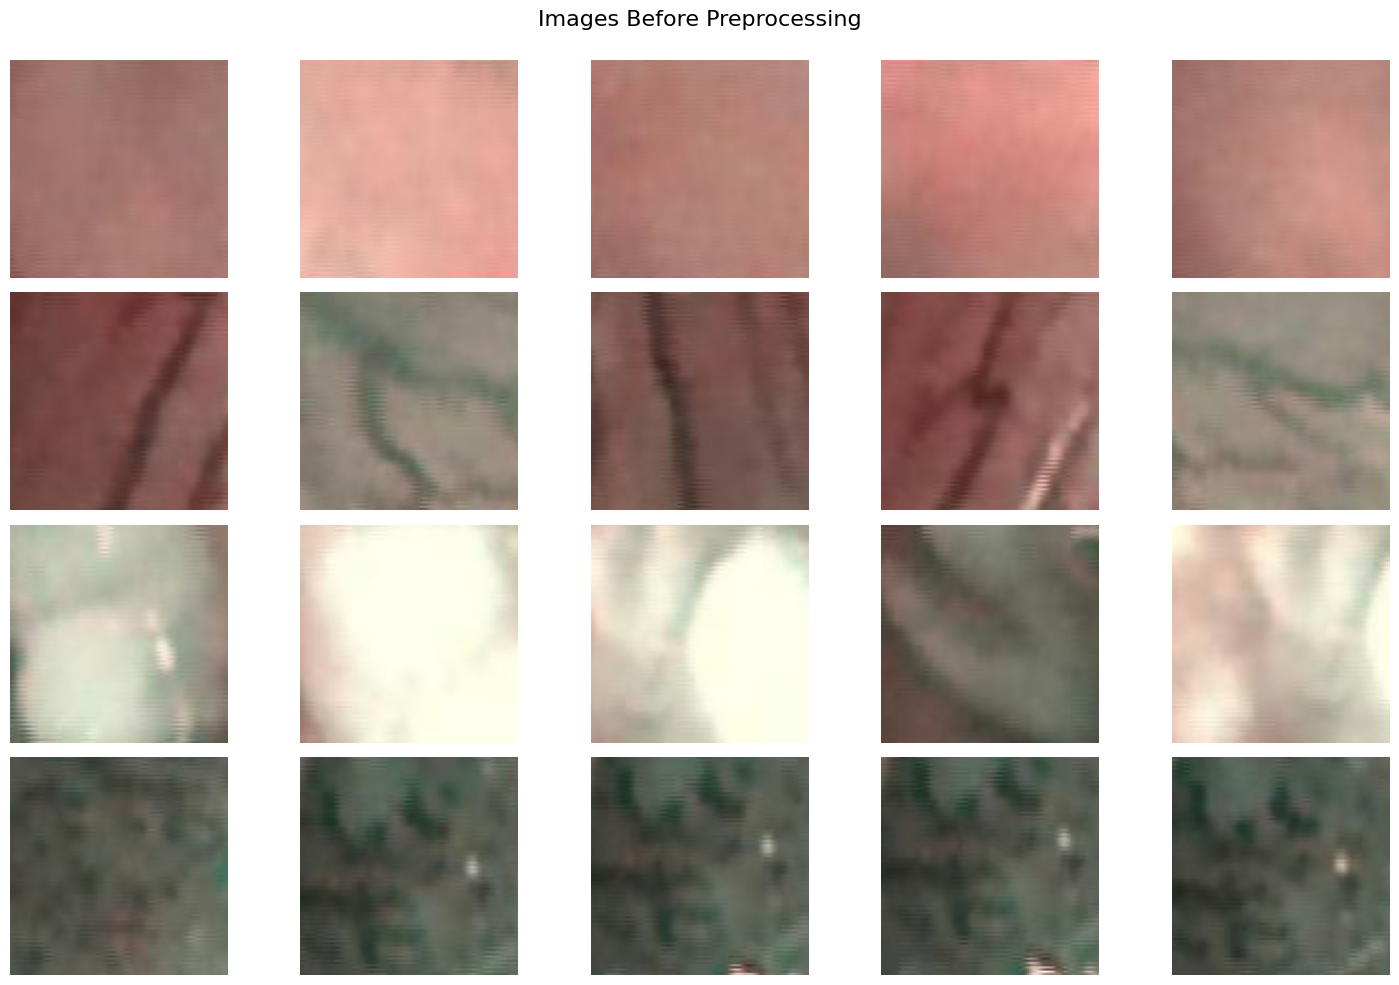

In [6]:
# Display images before preprocessing
display_sample_images(images, labels, label_names, "Images Before Preprocessing")

In [7]:
# Apply Gaussian filter
images_filtered = apply_gaussian_filter(images)
# images_Sharpened = apply_sharpening(images_filtered)     Giving 97% accuracy
# images_super_resolution = apply_gamma_correction(images_filtered)   Giving 97% accuracy

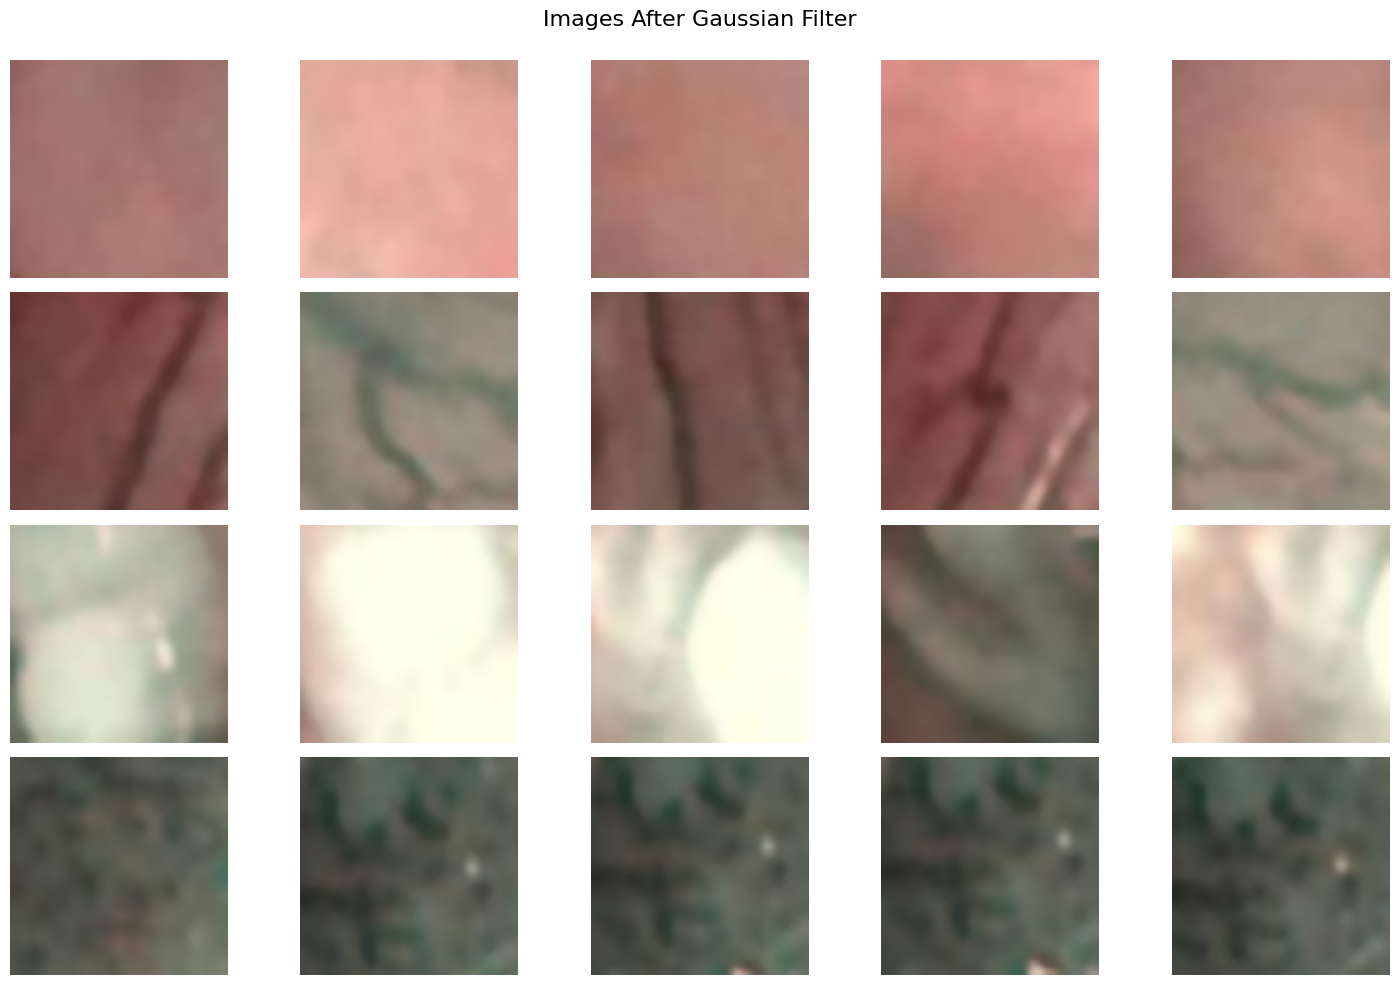

In [8]:
# Display images after Gaussian filter
display_sample_images(images_filtered, labels, label_names, "Images After Gaussian Filter")

In [9]:
# Step 4: Preprocess images
images_vgg = preprocess_vgg(images_filtered.copy())
images_inception = preprocess_inception(images_filtered.copy())
images_densenet = preprocess_densenet(images_filtered.copy())
images_efficientnet = preprocess_efficientnet(images_filtered.copy())

In [10]:
# Step 5: Feature Extraction
def extract_features(model, images):
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

vgg_model = VGG16(include_top=False, input_shape=(100, 100, 3))
inception_model = InceptionV3(include_top=False, input_shape=(100, 100, 3))
densenet_model = DenseNet201(include_top=False, input_shape=(100, 100, 3))
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(100, 100, 3))

features_vgg = extract_features(vgg_model, images_vgg)
features_inception = extract_features(inception_model, images_inception)
features_densenet = extract_features(densenet_model, images_densenet)
features_efficientnet = extract_features(efficientnet_model, images_efficientnet)

# Combine features
features = np.hstack([features_vgg, features_vgg, features_densenet, features_efficientnet])


42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step


In [11]:
# Step 6: Encode labels
label_encoder = LabelEncoder()
labels_encoded1 = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded1)

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 3: Standardize the features
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(features)

# Step 4: Apply PCA
pca = PCA(n_components=200)  # Adjust the number of components as needed
fused_features_pca = pca.fit_transform(fused_features_scaled)

In [13]:
# Step 7: Split the data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(features,  labels_encoded, test_size=0.25, random_state=42)

# Normalize the input data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Ensure that the shape of the arrays is as expected
print("X_train shape after normalization:", X_train.shape)
print("X_test shape after normalization:", X_test.shape)

X_train shape after normalization: (990, 46976)
X_test shape after normalization: (330, 46976)


In [14]:
# Step 9: Train Neural Network classifier
def create_model(neurons=1, optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X_train.shape[1],), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(
    model=create_model, 
    epochs=10, 
    batch_size=32, 
    verbose=0,
    optimizer='adam',
    activation='relu' 
)

param_grid = {
    'model__neurons': [64, 128, 256, 512, 1024],
    'epochs': [20, 30, 50],
    # 'batch_size' : [32, 64, 128],
    'model__optimizer': ['sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh']
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, verbose=2)
grid_result = grid.fit(X_train, y_train)

print("Best parameters found: ", grid_result.best_params_)
print("Best cross-validation accuracy: ", grid_result.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  56.2s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time= 1.0min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  59.8s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  54.8s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  53.7s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  22.4s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  22.4s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  22.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  23.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=tanh, model__neurons=128, model__optimizer=rmsprop; total time=  22.0s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=rmsprop; total time= 1.6min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=rmsprop; total time= 1.6min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=rmsprop; total time= 1.6min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=rmsprop; total time= 1.7min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=rmsprop; total time= 1.7min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=1024, model__optimizer=sgd; total time=  52.1s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=1024, model__optimizer=sgd; total time=  50.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=1024, model__optimizer=sgd; total time=  51.2s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=1024, model__optimizer=sgd; total time=  49.2s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=1024, model__optimizer=sgd; total time=  49.1s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=sgd; total time=  38.8s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=sgd; total time=  38.4s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=sgd; total time=  38.9s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=sgd; total time=  39.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=512, model__optimizer=sgd; total time=  42.1s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  21.4s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  20.6s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  20.6s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  20.6s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  20.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=128, model__optimizer=rmsprop; total time=  22.1s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=128, model__optimizer=rmsprop; total time=  22.5s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=128, model__optimizer=rmsprop; total time=  22.3s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=128, model__optimizer=rmsprop; total time=  21.9s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=20, model__activation=relu, model__neurons=128, model__optimizer=rmsprop; total time=  22.7s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=1024, model__optimizer=sgd; total time= 1.2min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=1024, model__optimizer=sgd; total time= 1.2min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=1024, model__optimizer=sgd; total time= 1.3min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=1024, model__optimizer=sgd; total time= 1.2min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=tanh, model__neurons=1024, model__optimizer=sgd; total time= 1.2min


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  32.8s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  33.0s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  33.0s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  35.0s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=50, model__activation=tanh, model__neurons=64, model__optimizer=rmsprop; total time=  34.0s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=relu, model__neurons=256, model__optimizer=sgd; total time=  24.7s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=relu, model__neurons=256, model__optimizer=sgd; total time=  23.9s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=relu, model__neurons=256, model__optimizer=sgd; total time=  24.1s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=relu, model__neurons=256, model__optimizer=sgd; total time=  24.6s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END epochs=30, model__activation=relu, model__neurons=256, model__optimizer=sgd; total time=  24.2s


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters found:  {'model__optimizer': 'rmsprop', 'model__neurons': 128, 'model__activation': 'tanh', 'epochs': 50}
Best cross-validation accuracy:  0.9969696969696968


In [15]:
# Step 10: Evaluate the tuned Neural Network classifier
nn_best = grid_result.best_estimator_
nn_preds = nn_best.predict(X_test)
nn_preds_decoded = np.argmax(nn_preds, axis=1)
print("Tuned Neural Network Accuracy:", accuracy_score(y_test.argmax(axis=1), nn_preds_decoded))
print(classification_report(y_test.argmax(axis=1), nn_preds_decoded))

Tuned Neural Network Accuracy: 0.990909090909091
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        81
           1       0.99      1.00      0.99        78
           2       0.98      1.00      0.99        87
           3       1.00      1.00      1.00        84

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330



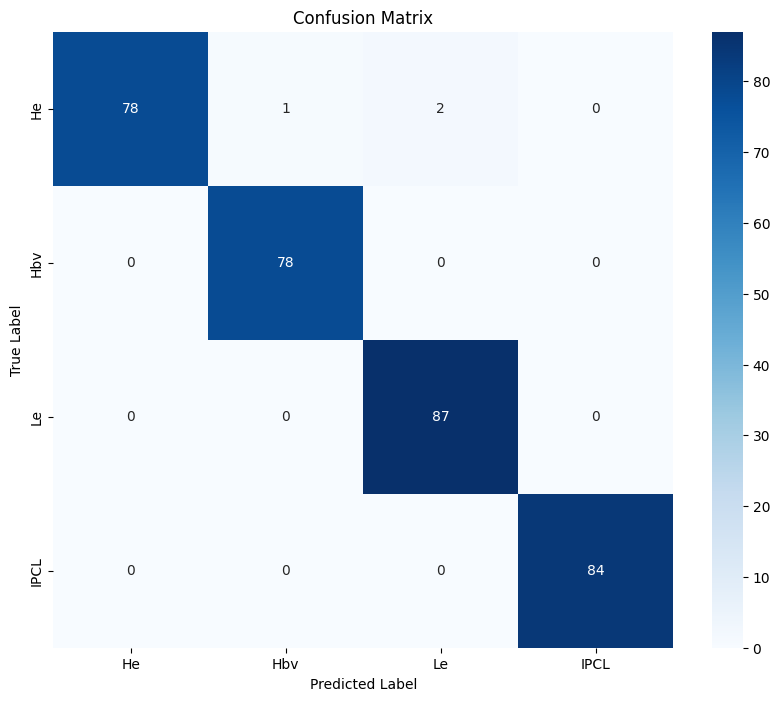

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test.argmax(axis = 1), nn_preds_decoded)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()